# Aberration Corrections

$T_{basis}=T_{out_{basis}}^*  T_{SLM} T_{in_{basis}}^{\dagger}$

thus,

$T_{SLM}=T_{out_{LG}}^T  T_{LG}  T_{in_{LG}}$

With Aberrations,


In [1]:
try:
    import cupy as cp
except ImportError:
    print('Couldn\'t import cupy')
import numpy as np
    
import matplotlib.pyplot as plt
from zernike import RZern
import matlab.engine
import time

In [2]:
#Tsim=unitary_group.rvs(N)
eng=matlab.engine.connect_matlab(matlab.engine.find_matlab()[0])

In [ ]:
Tin=eng.workspace['Tin_LG']
Tin=(np.array(Tin._real)+1j*np.array(Tin._imag)).reshape(Tin.size, order='F')

In [4]:
Tout=eng.workspace['Tout_LG']
Tout=(np.array(Tout._real)+1j*np.array(Tout._imag)).reshape(Tout.size, order='F')

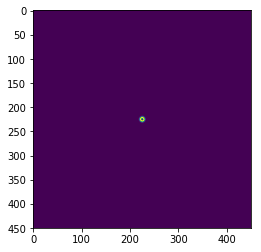

In [11]:
mode=Tin[10].reshape((W,H))
plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mode))))

# Aberrations on Real and Fourier Plane

In [ ]:
# Generate Phase Zernikies
W=450#np.sqrt(Tin.shape[1]).astype(int)
H=W
NN=int(H*W)
F=[]
for i in range(NN):
    inx=cp.zeros(NN)
    inx[i]=1
    F.append(np.fft.fftshift(np.fft.fftn(inx.reshape((W,H)) )).reshape(W*H).get())
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


In [25]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()


In [ ]:
NN/100

# Aberrations on Real Plane

In [5]:
# Generate Phase Zernikies

maxmg=5
cart = RZern(maxmg)
W=np.sqrt(Tin.shape[1]).astype(int)
H=W
ddx = np.linspace(-1.0, 1.0, W)
ddy = np.linspace(-1.0, 1.0, H)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

c=np.eye(cart.nk)
Tz=np.array([ cart.eval_grid(coeff, matrix=False) for coeff in c])
Tz=np.nan_to_num(Tz)#,nan=1)

Tz=np.array([np.exp(1j*np.pi*t/np.max(t))  for t in Tz])
Tz=np.array([t/np.linalg.norm(t) for t in Tz])
Tz.shape


(21, 202500)

In [9]:
# Tz/=np.sqrt(Tz.shape[0])
# Tin/=np.sqrt(Tin.shape[0])
# Tout/=np.sqrt(Tout.shape[0])


In [10]:
np.linalg.norm(Tout)

1.0000000004987337

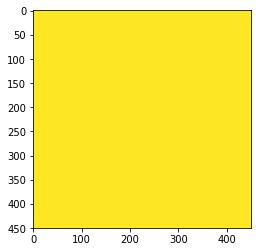

In [11]:
plt.imshow(np.abs(np.reshape(Tz[0],(450,450))),vmin=0)

In [12]:
# batches=5
# for part in range(batches):
#     id1=part*np.ceil(N/batches).astype(int)
#     id2=(part+1)*np.ceil(N/batches).astype(int)
#     print(id1,id2)

In [13]:
start_time = time.time()
batches=3
Win=cp.empty((Tin.shape[0],Tin.shape[0],Tz.shape[0]),dtype=np.complex128)

N=Tin.shape[0]
for part in range(batches):
    id1=part*np.ceil(N/batches).astype(int)
    id2=(part+1)*np.ceil(N/batches).astype(int)
    for o in range(Tin.shape[0]):
        Win[o,id1:id2,:]=cp.einsum('i,ji,ki->jk',Tin.conj().T[:,o],Tin[id1:id2,:],Tz)
print(time.time()-start_time)

262.4497036933899


In [14]:
Win=Win.get()

In [15]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [16]:
start_time = time.time()
batches=3
Wout=cp.empty((Tout.shape[0],Tout.shape[0],Tz.shape[0]),dtype=np.complex128)

N=Tout.shape[0]
for part in range(batches):
    id1=part*np.ceil(N/batches).astype(int)
    id2=(part+1)*np.ceil(N/batches).astype(int)
    for o in range(Tin.shape[0]):
        Wout[o,id1:id2,:]=cp.einsum('i,ji,ki->jk',Tin.conj().T[:,o],Tin[id1:id2,:],Tz)
        
print(time.time()-start_time)

262.01164174079895


In [17]:
Wout=Wout.get()

In [18]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [42]:
#np.einsum('io,ji,ki->ojk',Tin.conj().T,Tin,Tz)#.shape

In [19]:
np.save('Win_28_07_LG_norm',Win)
np.save('Wout_28_07_LG_norm',Wout)# 

In [20]:
Win=np.load('Win_28_07_LG_norm.npy')

In [21]:
Wout=np.load('Wout_28_07_LG_norm.npy')

In [22]:
np.linalg.norm(Win)

0.0001504857400469765

# Correction

In [23]:
from ComplexNets import *

In [25]:
a=np.zeros(21)
a[0]=1
N=199
a/=np.linalg.norm(a)
fac_Win=cp.einsum('ijk,k->ij',Win,a).get()[0,0] #)/np.sqrt(N)
fac_Wout=cp.einsum('ijk,k->ij',Wout,a).get()[0,0]#)/np.sqrt(N)

In [26]:
Win=Win/fac_Win
Wout=Wout/fac_Wout

In [27]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

In [28]:
T_old=eng.workspace['T_LG']
T_old=(np.array(T_old._real)+1j*np.array(T_old._imag)).reshape(T_old.size, order='F')

In [29]:
N=len(T_old)
T_old.shape

(199, 199)

In [30]:
T_old/=np.linalg.norm(T_old)

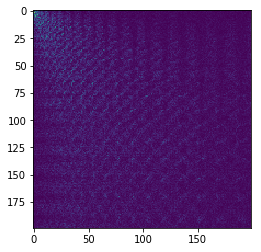

In [31]:
plt.imshow(np.abs(T_old))

In [56]:
class AberrationRealLayer(Layer):

    def __init__(self, Win,Wout,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 **kwargs):
        super(AberrationRealLayer, self).__init__(**kwargs)
        self.Win = Win
        self.Wout=Wout
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint=tf.keras.constraints.MaxNorm(
                                                            max_value=2, axis=0
                                                        )
        

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.Win.shape[2], 2, 2),
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint,
                                      trainable=True)

        super(AberrationRealLayer, self).build(input_shape)

    def call(self, T):
        # True Complex Multiplication (by channel combination)
        Tc = channels_to_complex(T)
       
        a1=channels_to_complex(self.kernel[:,0,:])
         
        a2=channels_to_complex(self.kernel[:,1,:])
        a1=a1/tf.linalg.norm(a1)
        a2=a2/tf.linalg.norm(a2)
        #print([a.shape for a in [self.Wout,a1,self.Win,a2,Tc]])
        newTc = tf.einsum('ila,a,jkb,b,...ij->...lk',self.Wout,a1,self.Win,a2,Tc)
        #print(newTc.shape)
        output = complex_to_channels(newTc)
        #print(output.shape)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape)

    def get_config(self):
        config = {
           
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
           }
        base_config = super(AberrationRealLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [74]:
Tt=complex_to_channels_np(T_old)

Wintf=tf.constant(Win.astype(np.complex64))
Wouttf=tf.constant(Wout.astype(np.complex64))

In [75]:
aber_coeff_init=np.zeros((Win.shape[2], 2))
aber_coeff_init[0,:]=1#
def aber_init(shape, dtype=None):
    return tf.constant(complex_to_channels_np(aber_coeff_init),dtype=tf.float32)


# Model

In [76]:
import tensorflow.keras.backend as kb
def custom_loss(Ti,Tn):
    
    Tic = channels_to_complex(Ti)
    Tnc = channels_to_complex(Tn)
  #  print(Toc.shape)
    norm1=kb.sum( kb.square(kb.abs( Tic)))
    norm2=kb.sum( kb.square(kb.abs(Tnc)))
    #print(norm1,norm2)
    energy_ratio = norm1/norm2#( (tf.linalg.norm(Toc)/tf.linalg.norm(Tic)))**2
    print(energy_ratio)
    loss=energy_ratio
    #custom_loss=kb.square(y_actual-y_pred)
    return loss#custom_loss

In [77]:
Ti= keras.Input(shape=(N,N,2))

A=AberrationRealLayer(Wintf,Wouttf,kernel_initializer=aber_init)

To=A(Ti)

epochs = 200
batch_size =1
validation_split = 0.001
lr = 1e2
model = keras.models.Model(inputs=Ti, outputs=To)

model.compile(optimizer=keras.optimizers.SGD(lr=lr), loss=custom_loss)#,  metrics=['loss'])
#model.summary()

In [78]:
Tt_n= channels_to_complex(model.apply(np.array([Tt]))[0]).numpy()
T_oldm=Tt_n/np.linalg.norm(Tt_n)
Tt_n=complex_to_channels_np(T_oldm)

In [79]:
Tt_n= (model.apply(np.array([Tt_n]))[0]).numpy()
np.linalg.norm(Tt_n)

0.9933215


# Training

In [80]:
custom_loss(Tt_n,Tt_n)

tf.Tensor(1.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [81]:

history=model.fit(np.array([Tt_n]), 
          np.array([Tt_n]),
          epochs=200,
          batch_size=batch_size,
          #callbacks = [reduce_lr],
          verbose=1#,shuffle=True

                 )

Epoch 1/200
Tensor("custom_loss/truediv:0", shape=(), dtype=float32)
Tensor("custom_loss/truediv:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 379ms/step - loss: 1.0119
Epoch 2/200
1/1 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 6/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 11/200
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 12/200
1/1 [======

Text(0,0.5,'Loss')

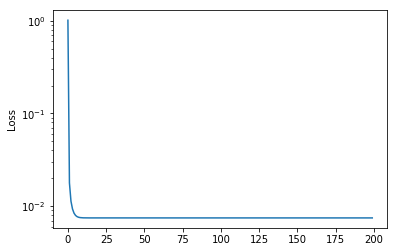

In [82]:
plt.plot(history.history['loss'])
plt.yscale("log")
plt.ylabel('Loss')

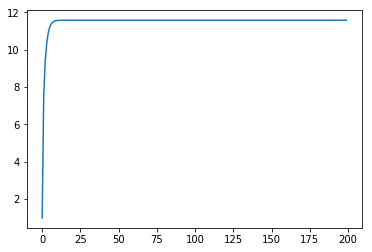

In [92]:
plt.plot(1/np.sqrt(np.array(history.history['loss'])))

In [83]:

weights=np.array( channels_to_complex(A.get_weights()[0]))
weights.shape
a1=weights[:,0]##weights[:,0]
#a1[0]=1
a2=weights[:,1]
T_new=cp.einsum('ila,a,jkb,b,ij->lk',Wout,a1,Win,a2,T_old)#.shape
T_new=T_new.get()

In [84]:
fac=np.abs(np.einsum('ijk,k->ij',Wout,a2))[0,0]

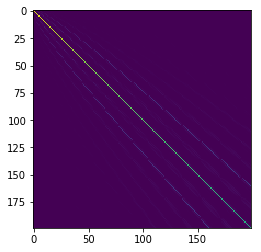

In [85]:
plt.imshow(np.abs(np.einsum('ijk,k->ij',Wout,a2)),vmin=0)

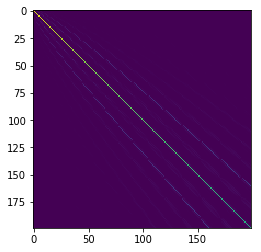

In [86]:
plt.imshow(np.abs(np.einsum('ijk,k->ij',Win,a2)),vmin=0)

In [87]:
T_new_tf= channels_to_complex(model.apply(np.array([Tt_n]))[0])
T_new=T_new_tf.numpy()

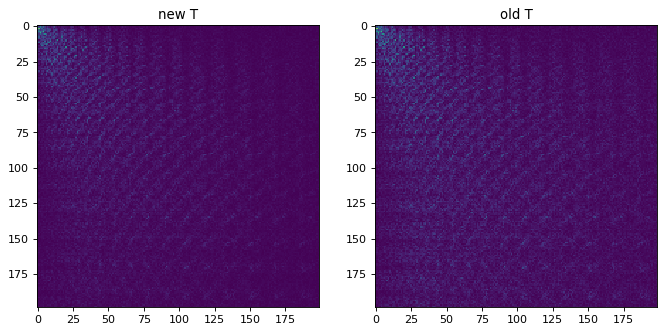

In [88]:
plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1,2,1)
plt.title('new T')
plt.imshow(np.abs(T_new),vmin=0)

plt.subplot(1,2,2)
plt.title('old T')
plt.imshow(np.abs(T_oldm),vmin=0)

In [89]:
print(f'New Norm: {np.linalg.norm(T_new)} Old Norm: {np.linalg.norm(T_oldm)}')

New Norm: 11.496060371398926 Old Norm: 1.0


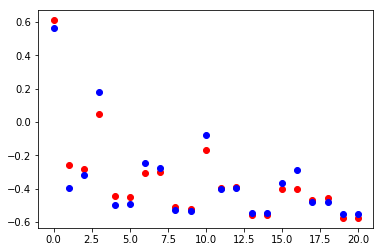

In [73]:
plt.plot(np.real(a1),'ro')
plt.plot(np.real(a2),'bo')

In [50]:
from scipy.linalg import block_diag

N=199

mask_near_degenerate=np.eye(N)

maxMG=np.ceil((-1+np.sqrt(1+8*N))/2).astype(int);

bg=[]
for i in range(maxMG):
    shape= i+1#int((i+1)*(i+2)/2)
    bg.append(np.ones( (shape,shape) ))
block_diag_mask=block_diag(*bg)[:199,:199]

In [51]:

np.linalg.norm(block_diag_mask*T_new)

3.920035308372937

In [52]:

np.linalg.norm(block_diag_mask*T_oldm)

0.3131812456042617